In [1]:
# apt-get update
# apt-get -y install libgl1-mesa-glx
# apt-get install libglib2.0-0
import os
import cv2
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import torchvision.transforms as transforms
import torch
import random
import torch.nn.functional as F
import re
import math
from diffusers import DPMSolverMultistepScheduler
from models.stablediffusion import StableDiffusionPipeline
from models.unet_model import UNet2DConditionModel
from models.clip_encoder import CLIPTextModel
from matplotlib import pyplot as plt
from captum.attr import visualization
from tqdm import tqdm

import json


# Stable Diffusion Heatmapping

### Model Setting

In [2]:
def auto_device(obj = torch.device('cpu')):
    if isinstance(obj, torch.device):
        return torch.device(f'cuda:{cuda_num}' if torch.cuda.is_available() else 'cpu')

    if torch.cuda.is_available():
        return obj.to(f'cuda:{cuda_num}')

    return obj

def set_seed(seed: int, cuda_num) -> torch.Generator:
    random.seed(seed)
    # np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    gen = torch.Generator(device=torch.device(f'cuda:{cuda_num}'))
    gen.manual_seed(seed)
    return gen

# Model loading...
# model_id = "stabilityai/stable-diffusion-2-1"
model_id = "CompVis/stable-diffusion-v1-4"
cuda_num = 1

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= f"{cuda_num}"  # Set the GPUs 2 and 3 to use
device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet", torch_dtype=torch.float16)
clip_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder", torch_dtype=torch.float16)
pipe.text_encoder = clip_encoder
pipe.unet = unet
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(f"cuda:{cuda_num}")
net = torch.nn.DataParallel(pipe).to(device)
pipe = net.module
# pipe.unet.config.sample_size = 80

print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.67it/s]


Current cuda device: 0
Count of using GPUs: 4


In [3]:
def avg_heads(cam, grad):
    cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1])
    if grad is not None:
        grad = grad.reshape(-1, grad.shape[-2], grad.shape[-1])
        cam = grad * cam
    # Only take positive : Final attention map
    cam = cam.clamp(min=0).mean(dim=0)
    return cam

def apply_self_attention_rules(R_ss, R_sq, cam_ss):
    R_sq_addition = torch.matmul(cam_ss, R_sq)
    R_ss_addition = torch.matmul(cam_ss, R_ss)
    return R_ss_addition, R_sq_addition


def handle_residual(orig_self_attention):
    self_attention = orig_self_attention.clone()
    diag_idx = range(self_attention.shape[-1])
    self_attention -= torch.eye(self_attention.shape[-1]).to(self_attention.device)
    # assert self_attention[diag_idx, diag_idx].min() >= 0
    self_attention[diag_idx, diag_idx].clamp(min=0)
    self_attention = self_attention / self_attention.sum(dim=-1, keepdim=True)
    self_attention += torch.eye(self_attention.shape[-1]).to(self_attention.device)
    return self_attention

def apply_mm_attention_rules(R_ss, R_qq, cam_sq, apply_normalization=True, apply_self_in_rule_10=True):
    R_ss_normalized = R_ss
    R_qq_normalized = R_qq
    if apply_normalization:
        R_ss_normalized = handle_residual(R_ss)
        R_qq_normalized = handle_residual(R_qq)
    R_sq_addition = torch.matmul(R_ss_normalized.t(), torch.matmul(cam_sq, R_qq_normalized))
    if not apply_self_in_rule_10:
        R_sq_addition = cam_sq
    R_sq_addition[torch.isnan(R_sq_addition)] = 0
    
    return R_sq_addition


def get_img_relevance(cam, grad, mode, img_size):
    if mode == "self":
        rel = avg_heads(cam, grad)
        if rel.shape[-1] != img_size:
            rel = rel.unsqueeze(0).unsqueeze(0)
            rel = F.interpolate(rel, size=(img_size, img_size))
            rel = rel.squeeze(0).squeeze(0)
    elif mode == "cross":
        if grad is not None:
            rel = avg_heads(cam, grad)
        else:
            rel = cam.clamp(min=0).mean(dim=0)
        if rel.shape[-2] != img_size:
            rel = rel.unsqueeze(0).unsqueeze(0)
            rel = F.interpolate(rel, size=(img_size, rel.shape[-1]))
            rel = rel.squeeze(0).squeeze(0)
    else:
        raise ValueError("mode should be either self or cross")
    return rel

unet_config = {
    "up" : [
        [],
        [1,2,3],
        [1,2,3],
        [1,2,3],
            ],
    "down" : [
        [1,2],
        [1,2],
        [1,2],
        {},
        ],
    "mid" : [[1]]
    }

def get_relevance_map(pipeline, logit, tokens_lst, heatmap = False, step_vis=0):

    image_bboxes = pipeline.unet.down_blocks[0].attentions[0].transformer_blocks[0].attn1.get_attn().shape[-1]
    self_queries_num =  pipeline.text_encoder.text_model.encoder.layers[0].self_attn.get_attn().shape[-1]
    queries_num = pipeline.unet.down_blocks[0].attentions[0].transformer_blocks[0].attn2.get_attn().shape[-1]
    # image self attention matrix
    R_i_i = torch.eye(image_bboxes, image_bboxes, dtype = torch.float16).to(pipeline.unet.device)
    # queries self attention matrix
    R_q_q = torch.eye(self_queries_num, self_queries_num,  dtype = torch.float16).to(pipeline.unet.device)
    # impact of image boxes on queries
    # R_q_i = torch.zeros(self_queries_num, image_bboxes).to(encoder_blocks[0].self_attn.attn.device)
    R_i_q = torch.zeros(image_bboxes, self_queries_num,  dtype = torch.float16).to(pipeline.unet.device)

    layers = pipeline.text_encoder.text_model.encoder.layers

    # Text self attention map
    for enc_layer in layers:
        attn = enc_layer.self_attn.get_attn()
        logit_sum = pipeline.text_embeddings.sum()
        grad = torch.autograd.grad(logit_sum, attn, retain_graph=True)[0]
        cam = enc_layer.self_attn.get_attn().detach()
        cam = avg_heads(cam, grad)
        rel = cam.clamp(min=0).mean(dim=0)
        R_q_q += torch.matmul(rel, R_q_q)
    
    # Cross attention map
    for blk_name, blocks in unet_config.items():
        if blk_name == "up":
            for blk_num, blk in enumerate(blocks):
                if len(blk) == 0:
                    continue
                for layer in blk:
                    grad = torch.autograd.grad(logit.sample.sum(), pipe.unet.up_blocks[blk_num].attentions[layer-1].transformer_blocks[0].attn1.get_attn(), retain_graph=True)[0].detach()
                    cam = pipeline.unet.up_blocks[blk_num].attentions[layer-1].transformer_blocks[0].attn1.get_attn().detach()
                    r_i = get_img_relevance(cam, grad, mode="self", img_size= image_bboxes)
                    R_iq_addition = torch.matmul(r_i, R_i_q)
                    R_ii_addition = torch.matmul(r_i, R_i_i)
                    R_i_q += R_iq_addition
                    R_i_i += R_ii_addition

                    if R_i_q.sum() == 0:
                        pass
                    else:
                        R_i_q = torch.nn.functional.normalize(R_i_q, dim = -1)

                    grad_cross = torch.autograd.grad(logit.sample.sum(), pipeline.unet.up_blocks[blk_num].attentions[layer-1].transformer_blocks[0].attn2.get_attn(), retain_graph=True)[0].detach()
                    cam_cross = pipeline.unet.up_blocks[blk_num].attentions[layer-1].transformer_blocks[0].attn2.get_attn().detach()
                    cam_i_q = get_img_relevance( cam_cross, grad_cross, mode="cross", img_size= image_bboxes)
                    R_i_q += apply_mm_attention_rules(R_i_i, R_q_q, cam_i_q,apply_normalization=True,apply_self_in_rule_10=True)
        elif blk_name == "down":
            for blk_num, blk in enumerate(blocks):
                if len(blk) == 0:
                    continue
                for layer in blk:
                    grad = torch.autograd.grad(logit.sample.sum(), pipe.unet.down_blocks[blk_num].attentions[layer-1].transformer_blocks[0].attn1.get_attn(), retain_graph=True)[0].detach()
                    cam = pipeline.unet.down_blocks[blk_num].attentions[layer-1].transformer_blocks[0].attn1.get_attn().detach()
                    r_i = get_img_relevance(cam, grad, mode="self", img_size= image_bboxes)
                    R_iq_addition = torch.matmul(r_i, R_i_q)
                    R_ii_addition = torch.matmul(r_i, R_i_i)

                    R_i_q += R_iq_addition
                    R_i_i += R_ii_addition
                    R_i_q = torch.nn.functional.normalize(R_i_q, dim = -1)

                    grad_cross = torch.autograd.grad(logit.sample.sum(),  pipeline.unet.down_blocks[blk_num].attentions[layer-1].transformer_blocks[0].attn2.get_attn(), retain_graph=True)[0].detach()
                    cam_cross = pipeline.unet.down_blocks[blk_num].attentions[layer-1].transformer_blocks[0].attn2.get_attn().detach()
                    cam_i_q = get_img_relevance(cam_cross, grad_cross, mode="cross", img_size= image_bboxes)
                    R_i_q += apply_mm_attention_rules(R_i_i, R_q_q, cam_i_q,apply_normalization=True,apply_self_in_rule_10=True)
        else:
            for blk_num, blk in enumerate(blocks):
                for layer in blk:
                    grad = torch.autograd.grad(logit.sample.sum(), pipe.unet.mid_block.attentions[layer-1].transformer_blocks[0].attn1.get_attn(), retain_graph=True)[0].detach()
                    cam = pipeline.unet.mid_block.attentions[layer-1].transformer_blocks[0].attn1.get_attn().detach()
                    r_i = get_img_relevance(cam, grad, mode="self", img_size= image_bboxes)
                    R_iq_addition = torch.matmul(r_i, R_i_q)
                    R_ii_addition = torch.matmul(r_i, R_i_i)
                    R_i_q += R_iq_addition
                    R_i_i += R_ii_addition

                    R_i_q = torch.nn.functional.normalize(R_i_q, dim = -1)
                    
                    grad_cross = torch.autograd.grad(logit.sample.sum(), pipeline.unet.mid_block.attentions[layer-1].transformer_blocks[0].attn2.get_attn(), retain_graph=True)[0].detach()
                    cam_cross = pipeline.unet.mid_block.attentions[layer-1].transformer_blocks[0].attn2.get_attn().detach()

                    cam_i_q = get_img_relevance(cam_cross, grad_cross, mode="cross", img_size= image_bboxes)
                    R_i_q += apply_mm_attention_rules(R_i_i, R_q_q, cam_i_q, apply_normalization=True,apply_self_in_rule_10=True)
    # Relevance map visualization
    relevance_map = R_i_q.sum(0)[1:len(tokens_lst)-1]
    relevance_map_min, relevance_map_max = relevance_map.min(), relevance_map.max()
    
    # normalization
    relevance_map = (relevance_map - relevance_map_min) / (relevance_map_max - relevance_map_min)
    word_lst = tokens_lst[1:-1]
    vis_data_records = [visualization.VisualizationDataRecord(
                                    relevance_map,
                                    0,
                                    0,
                                    step_vis,
                                    0,
                                    1,       
                                    word_lst,
                                    0)]
    # print([(word_lst[i], relevance_map[i].item()) for i in range(len(word_lst))])
    if heatmap:
        visualization.visualize_text(vis_data_records)
    return {word_lst[i]:relevance_map[i].item() for i in range(len(word_lst))}

In [16]:
import matplotlib.pyplot as plt
import random

def create_graph(ax, x, y, marker, linestyle, color, label=None):
    # 그래프를 생성합니다.
    ax.plot(x, y, marker=marker, linestyle=linestyle, color=color, label=label)

def create_rel_graph(relev_dict, num_step, mode):
    marker_list = [ 'x', '+', '^','.']
    linestyle_list = ['-', '--', '-.']
    color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    # custom_color = 

    x = list(range(1, num_step+1))
    words = list(relev_dict.keys())
    if mode == "word_changes":
        # 1x3 subplots
        fig, axes = plt.subplots(nrows=1, ncols=len(words), figsize=(20, 5))
        # Graph 1에 3개의 선을 그립니다.
        for idx, (word, rel_dicts) in enumerate(relev_dict.items()):
            for sampling_name, rel_score in rel_dicts.items():
                if sampling_name == "uniform":
                    create_graph(axes[idx], x, rel_score, marker= random.choice(marker_list), linestyle=random.choice(linestyle_list), color='k', label=f"{sampling_name}")
                elif sampling_name == "early":
                    create_graph(axes[idx], x, rel_score, marker= random.choice(marker_list), linestyle=random.choice(linestyle_list), color='r', label=f"{sampling_name}")
                elif sampling_name == "latter":
                    create_graph(axes[idx], x, rel_score, marker= random.choice(marker_list), linestyle=random.choice(linestyle_list), color='b', label=f"{sampling_name}")
            axes[idx].set_title(f"Token: {word}")
            axes[idx].set_xlabel('step')
            axes[idx].set_ylabel('relevance score')
            axes[idx].legend()
            axes[idx].grid(True)
            axes[idx].legend()

    elif mode == "sampling_changes":
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        color_list = []
        for idx, (sampling_name, word_dict) in enumerate(relev_dict.items()):
            for color_idx, (word, rel_score) in enumerate(word_dict.items()):
                if idx == 0:
                    color=(round(random.uniform(0, 1),1), round(random.uniform(0, 1),1), round(random.uniform(0, 1),1))
                    color_list.append(color)
                # create_graph(axes[idx], x, rel_score, marker= random.choice(marker_list), linestyle=random.choice(linestyle_list), color=color_list[color_idx], label=f"{word}")
                create_graph(axes[idx], x, rel_score, marker= random.choice(marker_list), linestyle=random.choice(linestyle_list), color=color_list[color_idx])

            axes[idx].set_xlabel('step')
            axes[idx].set_ylabel('relevance score')
            axes[idx].set_title(f"{sampling_name} sampling")
            axes[idx].legend()
            axes[idx].grid(True)
    elif mode == 'word_score':
        categories = list(relev_dict.keys())
        bar_count  = len(categories)

        word_lst = list(relev_dict[categories[0]].keys())
        word_num = len(word_lst)

        # x축에 표시할 위치
        x = np.arange(len(word_lst))
        width = 0.2  # 막대그래프의 너비
        fig, ax = plt.subplots()

        for idx, (sample_method, relev_scores) in enumerate(relev_dict.items()):
            ax.bar(x + idx*width, list(relev_scores.values()), width, label=f'{sample_method} sampling')
        ax.set_ylabel('Relevance score')
        ax.set_title('Tokens')
        ax.set_xticks(x + (width * (bar_count - 1)) / 2)
        ax.set_xticklabels(word_lst, rotation=45)  # x축 레이블을 45도 회전하여 표시
        ax.legend()

        plt.tight_layout()
        plt.show()
            
    else:
        raise ValueError("mode should be one of 'word changes' or 'sampling changes'")

# Prompt setting

In [5]:
data_dir = "/home/pr07/jh_park/data/karpathy_test_text.json"
import json
with open(data_dir, 'r') as file:
    data = json.load(file)

FileNotFoundError: [Errno 2] No such file or directory: '/home/pr07/jh_park/data/karpathy_test_text.json'

example2

In [6]:
data[11]["targets"]

'A young man wearing black attire and a flowered tie is standing and smiling.'

In [7]:
data[16]["targets"]

'Vegetables are displayed in a wooden barrel outdoors.'

example 3

In [9]:
data[2]["targets"]

'A man on a bicycle riding next to a train'

In [9]:
data[8]["targets"]

'people on bicycles ride down a busy street'

In [10]:
data[13]["targets"]

'A row of motorcycles parked in front of a building.'

In [51]:
data[15]["targets"]

'A painting of a table with fruit on top of it.'

example4

In [11]:
data[4]["targets"]

'A wooden ball on top of a wooden stick.'

In [14]:
data[7]["targets"]

'A bathroom with an enclosed shower next to a sink and a toilet.'

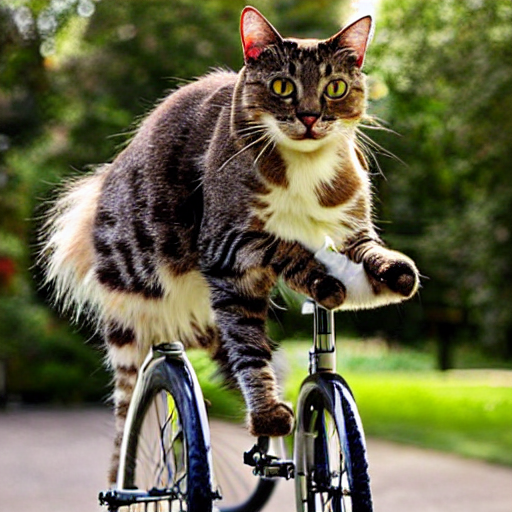

In [6]:
# prompt = "A photo of a cubic sushi"
prompt = "A portrait photo of a pig tied to red ribbon"
prompt = "A photo of a cat riding on a bicycle"
# prompt = "nurse and doctor"
out, logit, all_images = pipe(
    prompt,
    num_inference_steps=20,
    generator=set_seed(1, cuda_num),
    get_images_for_all_inference_steps = True,
    output_type = 'pil',
    step_visualization_num = 15,
    time_steps = None,
    visualization_mode = {'mode':"cam", 'mask':None , 'layer_vis' : False, "auc_options" : {"auc":False}}
    )
out['images'][0]

In [17]:
# prompt_txt = "a photo of an astronaut riding a horse"
# prompt_txt = "A photo of a man eating with fork"
# prompt_txt = 'Vegetables are displayed in a wooden barrel outdoors.'
# prompt_txt = "a cat and a dog sitting on a couch"
# prompt_txt = "castle with the hat of a wizard"
# prompt_txt = "a cat with a tie and a hat"
# prompt_txt = "a portrait photo of a man with a dog and a cat"
# prompt_txt = "a photo of a bear playing piano"
# prompt_txt = "A portrait photo of a Lego Arnold Schwarzenegger"
# prompt_txt = "A photo of a pig tied to red ribbon"
# prompt_txt = "A photo of boat on the sea with waves"
# prompt_txt = "A photo of boat with a flag"
prompt_txt = "a cat playing soccer"
# prompt_txt = "A photo of a surfing cat"
# prompt_txt = "A portrait photo of a docter singing a song"

# prompt_txt = "a photo of dog reading book"

# prompt_txt = "a photo of dog fighting with cat"
prompt_txt ="a portrait photo of an apple on the banana"
# prompt_txt = "a doctor, singing a song, male"
# prompt_txt = "A portrait photo of a bear riding a skateboard"
# prompt_txt = "A photo of a cubic sushi"
# prompt_txt = "A photo of a nurse"
# prompt_txt = "nurse and doctor"|
# prompt_txt = "A photo of a cat riding on a bicycle"
prompt_txt = "a photo of some plants surrounding a lightbulb"
prompt_txt = "A portrait photo of a giraffe and a zebra and a tiger"
prompt_txt = "A portrait photo of a zebra and a giraffe and a tiger"
prompt_txt = "a portrait photo of an apple on the banana"

text_inputs = pipe.tokenizer(
    prompt_txt,
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)
tokens_lst = []
for i in range(text_inputs.attention_mask.sum().item()):
    tokens_lst.append(pipe.tokenizer.convert_ids_to_tokens(text_inputs.input_ids[0][i].item()))

# Time step setting

In [18]:
def time_step_sampling(semantic_or_delicate, num_step, lamda):
    if lamda == 0:
        return None
    alpha = math.e ** (math.log(1000)/(num_step+lamda))
    if semantic_or_delicate == "semantic":
        time_steps = [1000-int(alpha ** (i+1+lamda))for i in range(num_step)]
        time_steps.insert(0, 999)
        time_steps.pop(-1)
        time_steps = np.array(time_steps)
        time_steps = torch.from_numpy(time_steps).to(device)
    elif semantic_or_delicate == "delicate":
        time_steps = [int(alpha ** (i+1+lamda))for i in range(num_step)]
        time_steps.sort(reverse=True)
        if time_steps[0] == 1000:
            time_steps[0] = 999
        time_steps = np.array(time_steps)
        time_steps = torch.from_numpy(time_steps).to(device)
    elif semantic_or_delicate == "uniform":
        time_steps = None
    else:
        raise ValueError
    return time_steps


# Figure 11

# Uniform vs Early vs Latter
the relevance score per word. x axis is step y is the word relevance score

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [02:16<00:00,  4.55s/it]


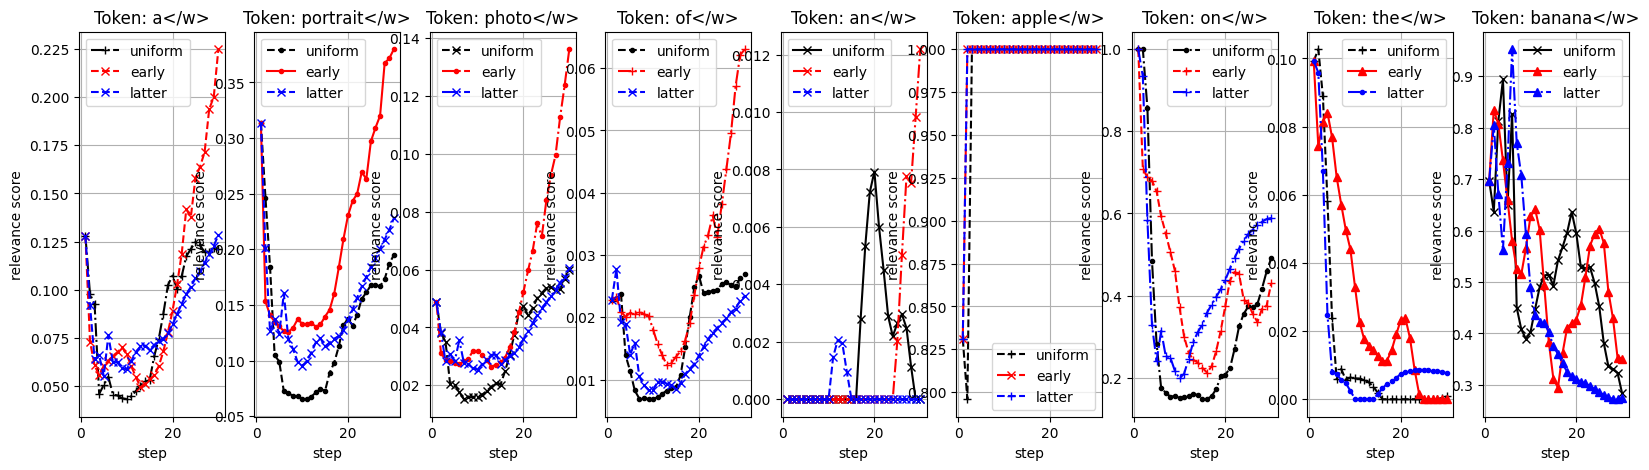

In [19]:
seed = 1
num_step = 30
lamda = 60
images_lst= []
for semantic_or_delicate in ["uniform", "delicate", "semantic"]:
    time_steps = time_step_sampling(semantic_or_delicate, num_step, lamda = lamda)
    for step_vis in tqdm(range(1, num_step+1)):
        image, logit = pipe(
            prompt_txt,
            num_inference_steps=num_step,
            generator=set_seed(seed, cuda_num),
            get_images_for_all_inference_steps = True,
            output_type = None,
            step_visualization_num = step_vis,
            time_steps = time_steps,
            visualization_mode = {'mode':"rel_map", 'mask':None , 'layer_vis' : False}
            )
        relevance_score = get_relevance_map(pipe, logit, tokens_lst, heatmap = False, step_vis=step_vis)

        if step_vis == 1 and semantic_or_delicate == "uniform":
            rel_dict = {}
            for word in relevance_score.keys():
                rel_dict[word] = {'uniform' : [], "early" : [], "latter" : []}
            for word, score in relevance_score.items():
                rel_dict[word]['uniform'].append(score)
            continue
        if semantic_or_delicate == "uniform":
            for word, score in relevance_score.items():
                rel_dict[word]['uniform'].append(score)
        elif semantic_or_delicate == "delicate":
            for word, score in relevance_score.items():
                rel_dict[word]['latter'].append(score)    
        elif semantic_or_delicate == "semantic":
            for word, score in relevance_score.items():
                rel_dict[word]['early'].append(score)
    images_lst.append(image[0])
    torch.cuda.empty_cache()
create_rel_graph(rel_dict, num_step, mode = "word_changes")
for idx, image in enumerate(images_lst):
    file_pth = f'outputs/crossattn_graph/images/{prompt_txt}'
    if not os.path.exists(file_pth):
        os.mkdir(file_pth)
    image.save(os.path.join(file_pth, f'{idx}.png'), 'png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


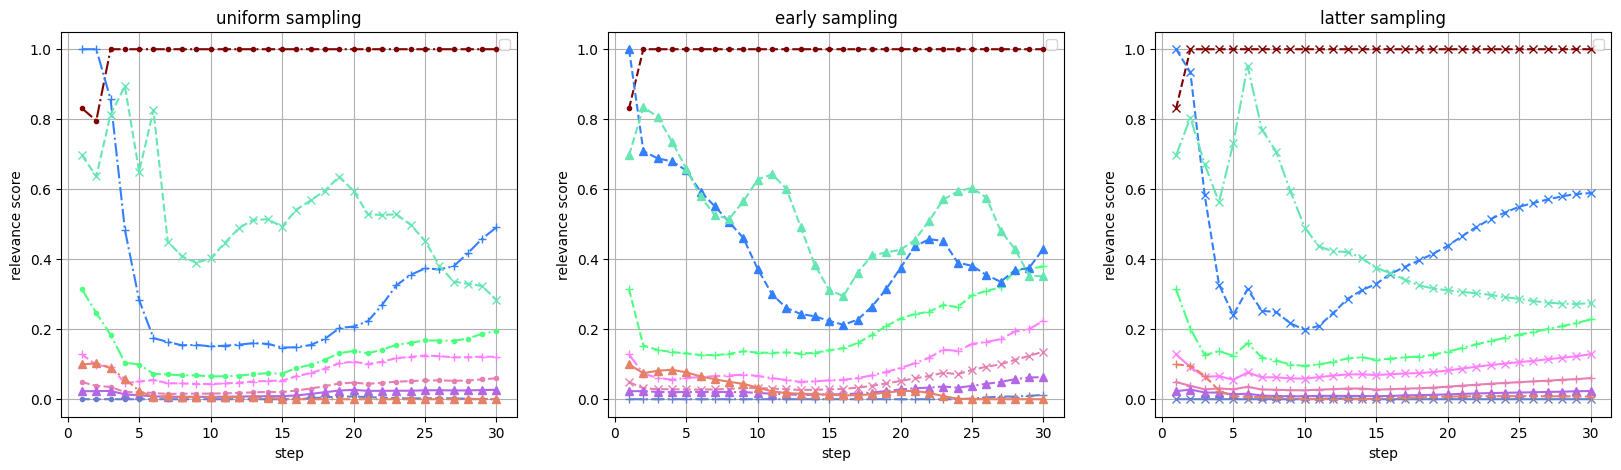

In [20]:
rel_dict2 = {'uniform':{}, "early":{}, "latter":{}}
for word, word_dict in rel_dict.items():
    for rel, rel_list in word_dict.items():
        if rel == 'uniform':
            rel_dict2[rel][word] = rel_list
        elif rel == 'early':
            rel_dict2['early'][word] = rel_list
        elif rel == 'latter':
            rel_dict2['latter'][word] = rel_list
create_rel_graph(rel_dict2, num_step, mode = "sampling_changes")

# Word score at each stage

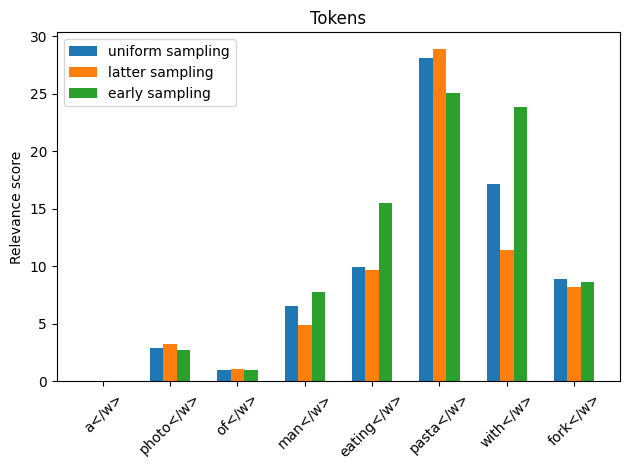

In [19]:
word_score = {'uniform': {}, 'latter': {}, 'early': {}}
for sampling_method, relev_score_dict in rel_dict2.items():
    for word, rel_score in relev_score_dict.items():
        word_score[sampling_method][word] = sum(rel_score)
create_rel_graph(word_score, num_step, mode = "word_score")

# Visual genome

In [7]:
import json
file_dir = "/home/pr07/jh_park/data/genome/relationships.json"
with open(file_dir, 'r') as f:
    data = json.load(f)

In [5]:
# Dataset preprocessing making sentence: {subject} {relation} {object}
file_dir = "/home/pr07/jh_park/data/genome/relationships.json"
output_dir = '/home/pr07/jh_park/data/genome/genome_dataset.json'
if os.path.exists(output_dir):
    with open(output_dir, 'r') as f:
        genome_dataset = json.load(f)
        
else:
    with open(file_dir, 'r') as f:
        data = json.load(f)
        
    object_dict = {}
    sentence_lst = []
    obj_file_dir = "/home/pr07/jh_park/data/genome/objects.json"
    with open(obj_file_dir, 'r') as f:
        objects_data = json.load(f)

    for obj in objects_data:
        for obj_dct in obj['objects']:
            object_dict[obj_dct["object_id"]] = obj_dct["names"][0]
            
    genome_dataset = []
    for data_dict in tqdm(data, desc="Making sentence..."):
        for relations in data_dict['relationships']:
            relation = relations['predicate']
            try:
                subject = relations['subject']['name']
                object_ = relations['object']['name']
            except:
                continue
            sentence = f"{subject} {relation} {object_}"
            if sentence in sentence_lst:
                continue
            sentence_lst.append(sentence)
            batch = {"subject": subject, "object": object_, "relation": relation, "sentence": sentence}
            genome_dataset.append(batch)
    with open('/home/pr07/jh_park/data/genome/genome_dataset.json', 'w') as f:
        json.dump(genome_dataset, f)

KeyboardInterrupt: 

In [6]:
file_dir = "/home/pr07/jh_park/data/genome/relationships.json"

with open(file_dir, 'r') as f:
    data = json.load(f)
    
object_dict = {}
sentence_lst = []
obj_file_dir = "/home/pr07/jh_park/data/genome/objects.json"
with open(obj_file_dir, 'r') as f:
    objects_data = json.load(f)

for obj in objects_data:
    for obj_dct in obj['objects']:
        object_dict[obj_dct["object_id"]] = obj_dct["names"][0]
        
genome_dataset = []
for data_dict in tqdm(data[:50], desc="Making sentence..."):
    for relations in data_dict['relationships']:
        relation = relations['predicate']
        try:
            subject = relations['subject']['name']
            object_ = relations['object']['name']
        except:
            continue
        sentence = f"{subject} {relation} {object_}"
        if sentence in sentence_lst:
            continue
        sentence_lst.append(sentence)
        batch = {"subject": subject, "object": object_, "relation": relation, "sentence": sentence}
        genome_dataset.append(batch)

Making sentence...: 100%|██████████| 50/50 [00:00<00:00, 3542.31it/s]


In [7]:
len(genome_dataset)

922

In [8]:
random.seed(1)
random.shuffle(genome_dataset)

In [8]:
seed = 1
num_step = 30
lamda = 60
new_word_score = {'uniform': {'subject': .0, "relation":.0, 'object':.0}, 'latter': {'subject': .0, "relation":.0, 'object':.0}, 'early': {'subject': .0, "relation":.0, 'object':.0}}
test_word_score = {'uniform': {}, 'latter': {}, 'early': {}}
records1 = []
records2 = []
for batch in tqdm(genome_dataset[:100], desc ="evaluation >>>"):
    prompt_txt = batch['sentence']
    text_inputs = pipe.tokenizer(
        prompt_txt,
        padding="max_length",
        max_length=pipe.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    tokens_lst = []
    for i in range(text_inputs.attention_mask.sum().item()):
        tokens_lst.append(pipe.tokenizer.convert_ids_to_tokens(text_inputs.input_ids[0][i].item()))

    for semantic_or_delicate in ["uniform", "delicate", "semantic"]:
        time_steps = time_step_sampling(semantic_or_delicate, num_step, lamda = lamda)
        for step_vis in tqdm(range(1, num_step+1)):
            image, logit = pipe(
                prompt_txt,
                num_inference_steps=num_step,
                generator=set_seed(seed, cuda_num),
                get_images_for_all_inference_steps = True,
                output_type = None,
                step_visualization_num = step_vis,
                time_steps = time_steps,
                visualization_mode = {'mode':"rel_map", 'mask':None , 'layer_vis' : False}
                )
            relevance_score = get_relevance_map(pipe, logit, tokens_lst, heatmap = False, step_vis=step_vis)
            if step_vis == 1 and semantic_or_delicate == "uniform":
                rel_dict = {}
                for word in relevance_score.keys():
                    rel_dict[word] = {'uniform' : [], "early" : [], "latter" : []}
                for word, score in relevance_score.items():
                    rel_dict[word]['uniform'].append(score)
                continue
            if semantic_or_delicate == "uniform":
                for word, score in relevance_score.items():
                    rel_dict[word]['uniform'].append(score)
            elif semantic_or_delicate == "delicate":
                for word, score in relevance_score.items():
                    rel_dict[word]['latter'].append(score)    
            elif semantic_or_delicate == "semantic":
                for word, score in relevance_score.items():
                    rel_dict[word]['early'].append(score)

    rel_dict2 = {'uniform':{}, "early":{}, "latter":{}}
    for word, word_dict in rel_dict.items():
        for rel, rel_list in word_dict.items():
            if rel == 'uniform':
                rel_dict2[rel][word] = rel_list
            elif rel == 'early':
                rel_dict2['early'][word] = rel_list
            elif rel == 'latter':
                rel_dict2['latter'][word] = rel_list
    word_score = {'uniform': {}, 'latter': {}, 'early': {}}
    for sampling_method, relev_score_dict in rel_dict2.items():
        for word, rel_score in relev_score_dict.items():
            word_score[sampling_method][word] = sum(rel_score)
    word_store = ""
    score_store = .0
    try:
        for sam_method, wd_score in word_score.items():
            for token, score in wd_score.items():
                if '</w>' in token:
                    preprocessed = re.sub('</w>', '', token)
                else:
                    preprocessed = token
                for attr in ['subject', 'relation', 'object']:
                    name = batch[attr].lower()
                    if preprocessed in name:
                        if preprocessed == name:
                            new_word_score[sam_method][attr] += score
                            test_word_score[sam_method][f'{attr}_{preprocessed}'] = score
                        else:
                            # if </w> in token, it need to space, if not, it is a word splited by BPE
                            if '</w>' in token:
                                preprocessed += " "
                            else:
                                preprocessed = token
                            word_store += preprocessed
                            score_store += score
                            if word_store[:-1] == name:
                                new_word_score[sam_method][attr] += score_store
                                test_word_score[sam_method][f'{attr}_{word_store[:-1]}'] = score_store
                                word_store = ""
                                score_store = .0
                    else:
                        pass
        records1.append(new_word_score)
        records2.append(test_word_score)
        test_word_score = {'uniform': {}, 'latter': {}, 'early': {}}
    except:
        print(word_score)
        test_word_score = {'uniform': {}, 'latter': {}, 'early': {}}
        pass

evaluation >>>:   0%|          | 0/100 [00:00<?, ?it/s]

evaluation >>>: 100%|██████████| 100/100 [11:09:00<00:00, 401.40s/it]


In [10]:
new_word_score

{'uniform': {'subject': 2117.3141717910767,
  'relation': 422.96717643737793,
  'object': 1800.4534349441528},
 'latter': {'subject': 2020.8704280853271,
  'relation': 423.5311245918274,
  'object': 1753.7427258491516},
 'early': {'subject': 1777.2222180366516,
  'relation': 473.6181128025055,
  'object': 1890.171824812889}}

In [9]:
new_word_scores

{'uniform': {'subject': 2161.490595817566,
  'relation': 299.7311831712723,
  'object': 1761.0945863723755},
 'latter': {'subject': 2130.2351129055023,
  'relation': 239.1174874305725,
  'object': 1798.8681235313416},
 'early': {'subject': 1957.8263404369354,
  'relation': 300.33902502059937,
  'object': 1851.6946806907654}}

In [13]:
genome_dataset[3]

{'subject': 'car',
 'object': 'street',
 'relation': 'moving down',
 'sentence': 'car moving down street'}

In [11]:
batch

{'subject': 'man',
 'object': 'shirt',
 'relation': 'has',
 'sentence': 'man has shirt'}

In [61]:
word_score

{'uniform': {'car</w>': 27.351318359375,
  'has</w>': 3.8800048828125,
  'head': 0.0,
  'light</w>': 16.0626220703125},
 'latter': {'car</w>': 28.193115234375,
  'has</w>': 3.664154052734375,
  'head': 0.0,
  'light</w>': 18.28759765625},
 'early': {'car</w>': 23.052734375,
  'has</w>': 3.277679443359375,
  'head': 0.0,
  'light</w>': 23.89013671875}}

In [90]:
import re
new_word_score = {'uniform': {'subject': .0, "relation":.0, 'object':.0}, 'latter': {'subject': .0, "relation":.0, 'object':.0}, 'early': {'subject': .0, "relation":.0, 'object':.0}}
word_store = ""
score_store = 0
for sam_method, wd_score in word_score.items():
    for token, score in wd_score.items():
        if '</w>' in token:
            preprocessed = re.sub('</w>', '', token)
        else:
            preprocessed = token
        for attr in ['subject', 'relation', 'object']:
            name = genome_dataset[0][attr]
            if preprocessed in name:
                if preprocessed == name:
                    new_word_score[sam_method][attr] += score
                else:
                    word_store += preprocessed
                    score_store += score
                    if word_store == name:
                        new_word_score[sam_method][attr] += score_store
                        word_store = ""
                        score_store = 0
            else:
                pass

In [91]:
new_word_score

{'uniform': {'subject': 27.351318359375,
  'relation': 3.8800048828125,
  'object': 16.0626220703125},
 'latter': {'subject': 28.193115234375,
  'relation': 3.664154052734375,
  'object': 18.28759765625},
 'early': {'subject': 23.052734375,
  'relation': 3.277679443359375,
  'object': 23.89013671875}}

In [62]:
genome_dataset[0]

{'subject': 'car',
 'object': 'headlight',
 'relation': 'has',
 'sentence': 'car has headlight'}

# Lambda comparison

In [ ]:
seed = 1
num_step = 30
semantic_or_delicate = "semantic"
for semantic_or_delicate in range():
    time_steps = time_step_sampling(semantic_or_delicate, num_step, lamda = lamda)
    for step_vis in tqdm(range(1, num_step+1)):
        image, logit = pipe(
            prompt_txt,
            num_inference_steps=num_step,
            generator=set_seed(seed, cuda_num),
            get_images_for_all_inference_steps = True,
            output_type = None,
            step_visualization_num = step_vis,
            time_steps = time_steps,
            visualization_mode = {'mode':"rel_map", 'mask':None , 'layer_vis' : False}
            )
        relevance_score = get_relevance_map(pipe, logit, tokens_lst, heatmap = False, step_vis=step_vis)

        if step_vis == 1 and semantic_or_delicate == "uniform":
            rel_dict = {}
            for word in relevance_score.keys():
                rel_dict[word] = {'uniform' : [], "early" : [], "latter" : []}
            for word, score in relevance_score.items():
                rel_dict[word]['uniform'].append(score)
            continue
        if semantic_or_delicate == "uniform":
            for word, score in relevance_score.items():
                rel_dict[word]['uniform'].append(score)
        elif semantic_or_delicate == "delicate":
            for word, score in relevance_score.items():
                rel_dict[word]['latter'].append(score)    
        elif semantic_or_delicate == "semantic":
            for word, score in relevance_score.items():
                rel_dict[word]['early'].append(score)

create_rel_graph(rel_dict, num_step)

In [113]:
def get_relevance_map(pipeline):

    image_bboxes = pipeline.unet.down_blocks[0].attentions[0].transformer_blocks[0].attn1.get_attn().shape[-1]
    self_queries_num =  pipeline.text_encoder.text_model.encoder.layers[0].self_attn.get_attn().shape[-1]
    queries_num = pipeline.unet.down_blocks[0].attentions[0].transformer_blocks[0].attn2.get_attn().shape[-1]
    # image self attention matrix
    R_i_i = torch.eye(image_bboxes, image_bboxes, dtype = torch.float16).to(pipeline.unet.device)
    # queries self attention matrix
    R_q_q = torch.eye(self_queries_num, self_queries_num,  dtype = torch.float16).to(pipeline.unet.device)
    # impact of image boxes on queries
    # R_q_i = torch.zeros(self_queries_num, image_bboxes).to(encoder_blocks[0].self_attn.attn.device)
    R_i_q = torch.zeros(image_bboxes, self_queries_num,  dtype = torch.float16).to(pipeline.unet.device)

    layers = pipeline.text_encoder.text_model.encoder.layers

    # Text self attention map
    for enc_layer in layers:
        attn = enc_layer.self_attn.get_attn()
        logit_sum = pipeline.text_embeddings.sum()
        # grad = torch.autograd.grad(logit_sum, attn, retain_graph=True)[0]
        cam = enc_layer.self_attn.get_attn().detach()
        # cam = avg_heads(cam, grad)
        rel = cam.clamp(min=0).mean(dim=0)
        R_q_q += torch.matmul(rel, R_q_q)
    
    # Cross attention map
    for blk_name, blocks in unet_config.items():
        if blk_name == "up":
            for blk_num, blk in enumerate(blocks):
                if len(blk) == 0:
                    continue
                for layer in blk:
                    cam = pipeline.unet.up_blocks[blk_num].attentions[layer-1].transformer_blocks[0].attn1.get_attn().detach()
                    r_i = get_img_relevance(cam, mode="self", img_size= image_bboxes)
                    R_iq_addition = torch.matmul(r_i, R_i_q)
                    R_ii_addition = torch.matmul(r_i, R_i_i)
                    R_i_q += R_iq_addition
                    R_i_i += R_ii_addition

                    if R_i_q.sum() == 0:
                        pass
                    else:
                        R_i_q = torch.nn.functional.normalize(R_i_q, dim = -1)

                    cam_cross = pipeline.unet.up_blocks[blk_num].attentions[layer-1].transformer_blocks[0].attn2.get_attn().detach()
                    cam_i_q = get_img_relevance( cam_cross, mode="cross", img_size= image_bboxes)
                    R_i_q += apply_mm_attention_rules(R_i_i, R_q_q, cam_i_q,apply_normalization=True,apply_self_in_rule_10=True)
        elif blk_name == "down":
            for blk_num, blk in enumerate(blocks):
                if len(blk) == 0:
                    continue
                for layer in blk:
                    cam = pipeline.unet.down_blocks[blk_num].attentions[layer-1].transformer_blocks[0].attn1.get_attn().detach()
                    r_i = get_img_relevance(cam, mode="self", img_size= image_bboxes)
                    R_iq_addition = torch.matmul(r_i, R_i_q)
                    R_ii_addition = torch.matmul(r_i, R_i_i)

                    R_i_q += R_iq_addition
                    R_i_i += R_ii_addition
                    R_i_q = torch.nn.functional.normalize(R_i_q, dim = -1)

                    cam_cross = pipeline.unet.down_blocks[blk_num].attentions[layer-1].transformer_blocks[0].attn2.get_attn().detach()
                    cam_i_q = get_img_relevance( cam_cross, mode="cross", img_size= image_bboxes)
                    R_i_q += apply_mm_attention_rules(R_i_i, R_q_q, cam_i_q,apply_normalization=True,apply_self_in_rule_10=True)
        else:
            for blk_num, blk in enumerate(blocks):
                for layer in blk:
                    cam = pipeline.unet.mid_block.attentions[layer-1].transformer_blocks[0].attn1.get_attn().detach()
                    r_i = get_img_relevance(cam, mode="self", img_size= image_bboxes)
                    R_iq_addition = torch.matmul(r_i, R_i_q)
                    R_ii_addition = torch.matmul(r_i, R_i_i)
                    R_i_q += R_iq_addition
                    R_i_i += R_ii_addition

                    R_i_q = torch.nn.functional.normalize(R_i_q, dim = -1)
                    
                    cam_cross = pipeline.unet.mid_block.attentions[layer-1].transformer_blocks[0].attn2.get_attn().detach()
                    cam_i_q = get_img_relevance( cam_cross, mode="cross", img_size= image_bboxes)
                    R_i_q += apply_mm_attention_rules(R_i_i, R_q_q, cam_i_q,apply_normalization=True,apply_self_in_rule_10=True)

    # Relevance map visualization
    relevance_map = R_i_q.sum(0)[1:len(tokens_lst)-1]
    relevance_map_min, relevance_map_max = relevance_map.min(), relevance_map.max()
    
    # normalization
    relevance_map = (relevance_map - relevance_map_min) / (relevance_map_max - relevance_map_min)
    word_lst = tokens_lst[1:-1]
    vis_data_records = [visualization.VisualizationDataRecord(
                                    relevance_map,
                                    0,
                                    0,
                                    step_vis,
                                    0,
                                    1,       
                                    word_lst,
                                    0)]
    print([(word_lst[i], relevance_map[i].item()) for i in range(len(word_lst))])
    visualization.visualize_text(vis_data_records)

# Co-attention

In [94]:
for blk_name, blocks in unet_config.items():
    if blk_name == "up":
        for blk_num, blk in enumerate(blocks):
            if len(blk) == 0:
                continue
            for layer in blk:
                grad = torch.autograd.grad(logit.sample.sum(), pipe.unet.up_blocks[blk_num].attentions[layer-1].transformer_blocks[0].attn1.get_attn(), retain_graph=True)[0].detach()
                cam = pipe.unet.up_blocks[blk_num].attentions[layer-1].transformer_blocks[0].attn1.get_attn().detach()
                r_i = get_img_relevance(grad,cam, mode="self", img_size= image_bboxes)
                R_iq_addition = torch.matmul(r_i, R_i_q)
                R_ii_addition = torch.matmul(r_i, R_i_i)
                R_i_q += R_iq_addition
                R_i_i += R_ii_addition

                if R_i_q.sum() == 0:
                    pass
                else:
                    R_i_q = torch.nn.functional.normalize(R_i_q, dim = -1)

                grad_cross = torch.autograd.grad(logit.sample.sum(), pipe.unet.up_blocks[blk_num].attentions[layer-1].transformer_blocks[0].attn2.get_attn(), retain_graph=True)[0].detach()
                cam_cross = pipe.unet.up_blocks[blk_num].attentions[layer-1].transformer_blocks[0].attn2.get_attn().detach()
                cam_i_q = get_img_relevance(grad_cross, cam_cross, mode="cross", img_size= image_bboxes)
                R_i_q += apply_mm_attention_rules(R_i_i, R_q_q, cam_i_q,apply_normalization=True,apply_self_in_rule_10=True)
    elif blk_name == "down":
        for blk_num, blk in enumerate(blocks):
            if len(blk) == 0:
                continue
            for layer in blk:
                grad = torch.autograd.grad(logit.sample.sum(), pipe.unet.down_blocks[blk_num].attentions[layer-1].transformer_blocks[0].attn1.get_attn(), retain_graph=True)[0].detach()
                cam = pipe.unet.down_blocks[blk_num].attentions[layer-1].transformer_blocks[0].attn1.get_attn().detach()
                r_i = get_img_relevance(grad,cam, mode="self", img_size= image_bboxes)
                R_iq_addition = torch.matmul(r_i, R_i_q)
                R_ii_addition = torch.matmul(r_i, R_i_i)

                R_i_q += R_iq_addition
                R_i_i += R_ii_addition
                R_i_q = torch.nn.functional.normalize(R_i_q, dim = -1)

                grad_cross = torch.autograd.grad(logit.sample.sum(), pipe.unet.down_blocks[blk_num].attentions[layer-1].transformer_blocks[0].attn2.get_attn(), retain_graph=True)[0].detach()
                cam_cross = pipe.unet.down_blocks[blk_num].attentions[layer-1].transformer_blocks[0].attn2.get_attn().detach()
                cam_i_q = get_img_relevance(grad_cross, cam_cross, mode="cross", img_size= image_bboxes)
                R_i_q += apply_mm_attention_rules(R_i_i, R_q_q, cam_i_q,apply_normalization=True,apply_self_in_rule_10=True)
    else:
        for blk_num, blk in enumerate(blocks):
            for layer in blk:
                grad = torch.autograd.grad(logit.sample.sum(), pipe.unet.mid_block.attentions[layer-1].transformer_blocks[0].attn1.get_attn(), retain_graph=True)[0].detach()
                cam = pipe.unet.mid_block.attentions[layer-1].transformer_blocks[0].attn1.get_attn().detach()
                r_i = get_img_relevance(grad,cam, mode="self", img_size= image_bboxes)
                R_iq_addition = torch.matmul(r_i, R_i_q)
                R_ii_addition = torch.matmul(r_i, R_i_i)
                R_i_q += R_iq_addition
                R_i_i += R_ii_addition

                R_i_q = torch.nn.functional.normalize(R_i_q, dim = -1)
                
                grad_cross = torch.autograd.grad(logit.sample.sum(), pipe.unet.mid_block.attentions[layer-1].transformer_blocks[0].attn2.get_attn(), retain_graph=True)[0].detach()
                cam_cross = pipe.unet.mid_block.attentions[layer-1].transformer_blocks[0].attn2.get_attn().detach()
                cam_i_q = get_img_relevance(grad_cross, cam_cross, mode="cross", img_size= image_bboxes)
                R_i_q += apply_mm_attention_rules(R_i_i, R_q_q, cam_i_q,apply_normalization=True,apply_self_in_rule_10=True)

In [108]:
from captum.attr import visualization
relevance_map = R_i_q.sum(0)[1:len(tokens_lst)-1]
relevance_map_min, relevance_map_max = relevance_map.min(), relevance_map.max()
# normalization
relevance_map = (relevance_map - relevance_map_min) / (relevance_map_max - relevance_map_min)
word_lst = tokens_lst[1:-1]
vis_data_records = [visualization.VisualizationDataRecord(
                                relevance_map,
                                0,
                                0,
                                step_vis,
                                0,
                                1,       
                                word_lst,
                                0)]
print([(word_lst[i], relevance_map[i].item()) for i in range(len(word_lst))])
visualization.visualize_text(vis_data_records)

[('a</w>', 1.0), ('photo</w>', 0.59912109375), ('of</w>', 0.256103515625), ('a</w>', 0.05487060546875), ('astronaut</w>', 0.830078125), ('riding</w>', 0.398681640625), ('a</w>', 0.0), ('horse</w>', 0.476318359375)]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
20,0 (0.00),0,1.00,a photo of a astronaut riding a horse


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
20,0 (0.00),0,1.00,a photo of a astronaut riding a horse


In [73]:
from captum.attr import visualization
# relevance_map = R_i_q.sum(0)[1:len(tokens_lst)-1]
vis_data_records = [visualization.VisualizationDataRecord(
                                relevance_map,
                                0,
                                1,
                                0,
                                0,
                                0,       
                                tokens_lst[1:-1],
                                1)]
visualization.visualize_text(vis_data_records)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,1 (0.00),0,0.00,a photo of a astronaut riding a horse


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,1 (0.00),0,0.00,a photo of a astronaut riding a horse


In [43]:
from captum.attr import visualization
word_prob = R_i_q.sum(0)[1:len(tokens_lst)-1]
# word_prob = torch.softmax(word_prob, dim = -1)
word_prob = torch.nn.functional.normalize(R_i_q.sum(0)[1:len(tokens_lst)-1], dim = -1)

vis_data_records = [visualization.VisualizationDataRecord(
                                word_prob,
                                0,
                                0,
                                0,
                                0,
                                0,       
                                tokens_lst[1:-1],
                                1)]
visualization.visualize_text(vis_data_records)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of a astronaut riding a horse


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of a astronaut riding a horse


In [51]:
R_i_q.sum(0)[1:len(tokens_lst)-1]

tensor([31.1875, 27.8281, 21.2344, 17.9219, 24.6094, 23.2031, 18.2500, 19.0938],
       device='cuda:1', dtype=torch.float16)

In [33]:
from captum.attr import visualization
word_prob = R_i_q.sum(0)[1:len(tokens_lst)-1]
# word_prob = torch.softmax(word_prob, dim = -1)
word_prob = torch.nn.functional.normalize(R_i_q.sum(0)[1:len(tokens_lst)-1], dim = -1)

vis_data_records = [visualization.VisualizationDataRecord(
                                word_prob,
                                0,
                                0,
                                0,
                                0,
                                0,       
                                tokens_lst[1:-1],
                                1)]
visualization.visualize_text(vis_data_records)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of a astronaut riding a horse


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of a astronaut riding a horse


In [11]:
R_i_q.sum(0)[1:len(tokens_lst)-1]

tensor([29.9219, 25.3281, 20.0156, 17.5938, 24.4531, 22.6094, 19.6719, 19.6875],
       device='cuda:1', dtype=torch.float16)

In [12]:
from captum.attr import visualization
word_prob = R_i_q.sum(0)[1:len(tokens_lst)-1]
# word_prob = torch.softmax(word_prob, dim = -1)
word_prob = torch.nn.functional.normalize(R_i_q.sum(0)[1:len(tokens_lst)-1], dim = -1)

vis_data_records = [visualization.VisualizationDataRecord(
                                word_prob,
                                0,
                                0,
                                0,
                                0,
                                0,       
                                tokens_lst[1:-1],
                                1)]
visualization.visualize_text(vis_data_records)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of a astronaut riding a horse


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of a astronaut riding a horse


In [22]:
R_i_q.sum(0)[1:len(tokens_lst)-1]

tensor([30.2031, 25.6875, 20.2188, 17.7812, 24.5938, 23.2656, 19.5469, 19.8906],
       device='cuda:1', dtype=torch.float16)

In [23]:
from captum.attr import visualization
word_prob = R_i_q.sum(0)[1:len(tokens_lst)-1]
# word_prob = torch.softmax(word_prob, dim = -1)
word_prob = torch.nn.functional.normalize(R_i_q.sum(0)[1:len(tokens_lst)-1], dim = -1)

vis_data_records = [visualization.VisualizationDataRecord(
                                word_prob,
                                0,
                                0,
                                0,
                                0,
                                0,       
                                tokens_lst[1:-1],
                                1)]
visualization.visualize_text(vis_data_records)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of a astronaut riding a horse


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of a astronaut riding a horse


## Exponential Scheduler time steps

In [7]:
# prompt = "A photo of a flying chicken"
# prompt = "A photo of an elephants in the refrigerator"
prompt = "A photo of a black unicorn"


In [286]:
num_step = 30
semantic_or_delicate = "semantic"
lamda = 60
alpha = math.e ** (math.log(1000)/(num_step+lamda))
if semantic_or_delicate == "semantic":
    time_steps = [1000-int(alpha ** (i+1+lamda))for i in range(num_step)]
    time_steps.insert(0, 999)
    time_steps.pop(-1)
elif semantic_or_delicate == "delicate":
    time_steps = [int(alpha ** (i+1+lamda))for i in range(num_step)]
    time_steps.sort(reverse=True)
    if time_steps[0] == 1000:
        time_steps[0] = 999
else:
    raise ValueError
time_steps = np.array(time_steps)
time_steps = torch.from_numpy(time_steps).to(device)
time_steps

tensor([999, 893, 884, 875, 865, 854, 842, 829, 816, 801, 785, 768, 749, 729,
        708, 684, 659, 632, 602, 571, 536, 499, 459, 416, 370, 319, 265, 206,
        143,  74], device='cuda:2')

lambda changing

In [8]:
inference_steps = 5
visualization_step = 5
seed_num = 0
torch.cuda.empty_cache()
output,_,_,  = pipe(
    prompt,
    num_inference_steps=num_step,
    generator=set_seed(seed_num),
    get_images_for_all_inference_steps = True,
    output_type ='pil',
    step_visualization_num = visualization_step,
    visualization_mode = {'mode' : "", 'mask' : "gaussian", 'layer_vis' : False},
    similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure"},
    time_steps = None,
    )
# semantic_or_delicate = "original"


# img_name = prompt.split("A photo of")[-1]
# output.images[0].save(os.path.join("outputs/lambda", f"{img_name}_{lamda}_{semantic_or_delicate}.png"))

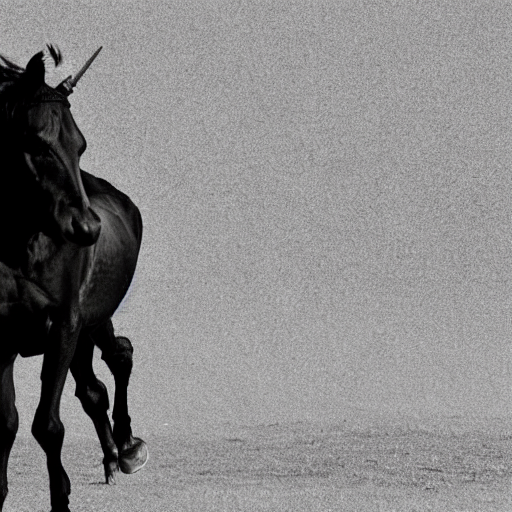

In [11]:
output["images"][0]

Only image generation

In [5]:
inference_steps = 5
visualization_step = 5
seed_num = 1
torch.cuda.empty_cache()
output,_,_,  = pipe(
    prompt,
    num_inference_steps=num_step,
    generator=set_seed(seed_num),
    get_images_for_all_inference_steps = True,
    output_type ='pil',
    step_visualization_num = visualization_step,
    visualization_mode = {'mode' : "", 'mask' : "gaussian", 'layer_vis' : False},
    similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure"},
    time_steps = time_steps,
    )
# semantic_or_delicate = "original"


img_name = prompt.split("A photo of")[-1]
output.images[0].save(os.path.join("outputs/sampling_output", f"{img_name}_{semantic_or_delicate}.png"))
# org_img = torch.from_numpy(all_images[-1][0]).permute(2,0,1)
# # Visualization
# plt.figure('Diffusion RISE', figsize=(10,4))
# plt.imshow(org_img.permute(1, 2, 0))
# plt.axis("off")

# if save:
#     plt.savefig(os.path.join(save_pth, f"{inference_steps}_{visualization_step}.png"))
# plt.show()
# torch.cuda.empty_cache()

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/sampling_output/ a black unicorn_delicate.png'

(1, 512, 512, 3)
(1, 512, 512, 3)
torch.Size([64, 64])


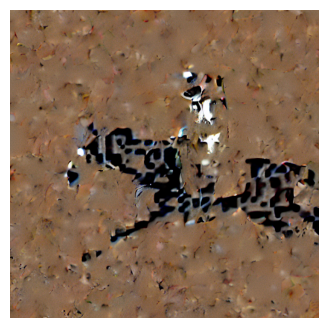

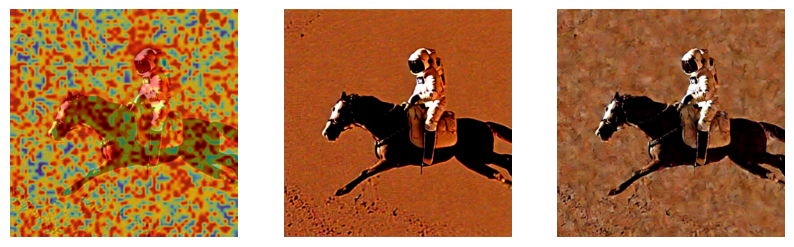

In [4]:
inference_steps = 20
visualization_step = 18
num_masks = 2
seed_num = 1
torch.cuda.empty_cache()
all_images, rise, auc_score, output = pipe(
    prompt,
    num_inference_steps=inference_steps,
    generator=set_seed(seed_num, cuda_num),
    get_images_for_all_inference_steps = True,
    output_type =None,
    step_visualization_num = visualization_step,
    visualization_mode = {'mode' : "rise", 'mask' : "gaussian", 'layer_vis' : False},
    rise_num_steps = num_masks,
    similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure"},
    time_steps = None,
    )
save = True
save_pth = f"./outputs/rise/ssim/v1.5/horse_austro_seed1"
if not os.path.exists(save_pth):
    os.mkdir(save_pth)

img_size = all_images[0].shape[1]

saliency_map = F.relu(rise).unsqueeze(0).unsqueeze(0)
saliency = saliency_map.clone()
# Upsampling
saliency_map = F.interpolate(saliency_map, size=(img_size, img_size), mode='bilinear', align_corners=False)

saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
# normalization
saliency_map = (saliency_map - saliency_map_min) / (saliency_map_max - saliency_map_min)

mask = saliency_map.cpu().data
mask = (mask - mask.min()).div(mask.max() - mask.min()).data
heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze().float()), cv2.COLORMAP_JET)  # [H, W, 3]
heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

org_img = torch.from_numpy(all_images[-1][0]).permute(2,0,1)
mask_sqz = mask.squeeze(0)
# original_cam = 1 * (1 - mask_sqz ** 0.8) * org_img + (mask_sqz ** 0.8) * heatmap
# original_gradcam = original_cam.cpu().detach().squeeze(0)

prev_noise = torch.from_numpy(all_images[visualization_step-1][0]).permute(2,0,1)
post_noise = torch.from_numpy(all_images[visualization_step][0]).permute(2,0,1)
# original_cam = 1 * (1 - mask_sqz ** 0.8) * prev_noise + (mask_sqz ** 0.8) * heatmap
original_cam = 1 * (1 - mask_sqz ** 0.8) * prev_noise + (mask_sqz ** 0.8) * heatmap
# original_cam = heatmap + prev_noise
original_gradcam = original_cam.cpu().detach().squeeze(0)
# Visualization
plt.figure('Diffusion RISE', figsize=(10,4))

# plt.subplot(1,4,1)
# plt.imshow(original_gradcam.permute(1, 2, 0))
# plt.axis("off")

plt.subplot(1,3,1)
plt.imshow(org_img.permute(1, 2, 0))
plt.imshow(heatmap.permute(1, 2, 0), alpha=0.5, cmap='viridis')
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(org_img.permute(1, 2, 0))
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(post_noise.permute(1, 2, 0))
plt.axis("off")
if save:
    plt.savefig(os.path.join(save_pth, f"{inference_steps}_{visualization_step}.png"))
plt.show()
torch.cuda.empty_cache()

### Diffusion RISE

(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)


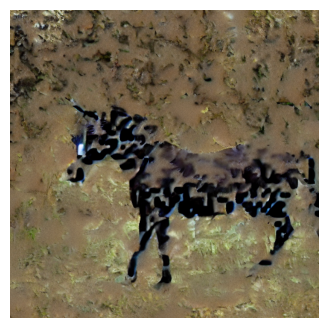

In [4]:
inference_steps = 20
visualization_step = 20
num_masks = 30
seed_num = 1

all_images, rise, auc_score, output = pipe(
    prompt,
    num_inference_steps=inference_steps,
    generator=set_seed(seed_num),
    get_images_for_all_inference_steps = True,
    output_type =None,
    step_visualization_num = visualization_step,
    visualization_mode = {'mode' : "rise", 'mask' : "gaussian", 'layer_vis' : False},
    rise_num_steps = num_masks,
    similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure"},
    time_steps = None,
    )
# save = True
# save_pth = f"./outputs/rise/ssim/v1.5/horse_austro_seed1"
# if not os.path.exists(save_pth):
#     os.mkdir(save_pth)

# img_size = all_images[0].shape[1]

# saliency_map = F.relu(rise).unsqueeze(0).unsqueeze(0)
# saliency = saliency_map.clone()
# # Upsampling
# saliency_map = F.interpolate(saliency_map, size=(img_size, img_size), mode='bilinear', align_corners=False)

# saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
# # normalization
# saliency_map = (saliency_map - saliency_map_min) / (saliency_map_max - saliency_map_min)

# mask = saliency_map.cpu().data
# mask = (mask - mask.min()).div(mask.max() - mask.min()).data
# heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze().float()), cv2.COLORMAP_JET)  # [H, W, 3]
# heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
# heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# org_img = torch.from_numpy(all_images[-1][0]).permute(2,0,1)
# mask_sqz = mask.squeeze(0)
# original_cam = 1 * (1 - mask_sqz ** 0.8) * org_img + (mask_sqz ** 0.8) * heatmap
# original_gradcam = original_cam.cpu().detach().squeeze(0)

# prev_noise = torch.from_numpy(all_images[visualization_step-1][0]).permute(2,0,1)
# post_noise = torch.from_numpy(all_images[visualization_step][0]).permute(2,0,1)

# # Visualization
# plt.figure('Diffusion RISE', figsize=(10,4))

# plt.subplot(1,4,1)
# plt.imshow(prev_noise.permute(1, 2, 0))
# plt.axis("off")

# plt.subplot(1,4,2)
# plt.imshow(heatmap.permute(1, 2, 0))
# plt.axis("off")

# plt.subplot(1,4,3)
# plt.imshow(original_cam.permute(1, 2, 0))
# plt.axis("off")

# plt.subplot(1,4,4)
# plt.imshow(post_noise.permute(1, 2, 0))
# plt.axis("off")
# if save:
#     plt.savefig(os.path.join(save_pth, f"{inference_steps}_{visualization_step}.png"))
# plt.show()


In [3]:
inference_steps = 20
visualization_step = 20
num_masks = 2
seed_num = 1

all_images, rise, auc_score, output = pipe(
    prompt,
    num_inference_steps=inference_steps,
    generator=set_seed(seed_num),
    get_images_for_all_inference_steps = True,
    output_type =None,
    step_visualization_num = visualization_step,
    visualization_mode = {'mode' : "rise", 'mask' : "gaussian", 'layer_vis' : False},
    rise_num_steps = num_masks,
    similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure"},
    time_steps = None,
    )
# save = True
# save_pth = f"./outputs/rise/ssim/v1.5/horse_austro_seed1"
# if not os.path.exists(save_pth):
#     os.mkdir(save_pth)

# img_size = all_images[0].shape[1]

# saliency_map = F.relu(rise).unsqueeze(0).unsqueeze(0)
# saliency = saliency_map.clone()
# # Upsampling
# saliency_map = F.interpolate(saliency_map, size=(img_size, img_size), mode='bilinear', align_corners=False)

# saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
# # normalization
# saliency_map = (saliency_map - saliency_map_min) / (saliency_map_max - saliency_map_min)

# mask = saliency_map.cpu().data
# mask = (mask - mask.min()).div(mask.max() - mask.min()).data
# heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze().float()), cv2.COLORMAP_JET)  # [H, W, 3]
# heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
# heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# org_img = torch.from_numpy(all_images[-1][0]).permute(2,0,1)
# mask_sqz = mask.squeeze(0)
# original_cam = 1 * (1 - mask_sqz ** 0.8) * org_img + (mask_sqz ** 0.8) * heatmap
# original_gradcam = original_cam.cpu().detach().squeeze(0)

# prev_noise = torch.from_numpy(all_images[visualization_step-1][0]).permute(2,0,1)
# post_noise = torch.from_numpy(all_images[visualization_step][0]).permute(2,0,1)

# # Visualization
# plt.figure('Diffusion RISE', figsize=(10,4))

# plt.subplot(1,4,1)
# plt.imshow(prev_noise.permute(1, 2, 0))
# plt.axis("off")

# plt.subplot(1,4,2)
# plt.imshow(heatmap.permute(1, 2, 0))
# plt.axis("off")

# plt.subplot(1,4,3)
# plt.imshow(original_cam.permute(1, 2, 0))
# plt.axis("off")

# plt.subplot(1,4,4)
# plt.imshow(post_noise.permute(1, 2, 0))
# plt.axis("off")
# if save:
#     plt.savefig(os.path.join(save_pth, f"{inference_steps}_{visualization_step}.png"))
# plt.show()


(1, 512, 512, 3)


RuntimeError: number of dims don't match in permute

<Figure size 1000x400 with 0 Axes>

FIgure for step visualization

In [ ]:
inference_steps = 20
visualization_step = 1
seed_num = 0
torch.cuda.empty_cache()
output,_,_,  = pipe(
    prompt,
    num_inference_steps=num_step,
    generator=set_seed(seed_num),
    get_images_for_all_inference_steps = True,
    output_type ='pil',
    step_visualization_num = visualization_step,
    visualization_mode = {'mode' : "", 'mask' : "gaussian", 'layer_vis' : False},
    similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure"},
    time_steps = None,
    )
semantic_or_delicate = "original"


img_name = prompt.split("A photo of")[-1]
output.images[0].save(os.path.join("outputs/sampling_output", f"{img_name}_{semantic_or_delicate}.png"))
# org_img = torch.from_numpy(all_images[-1][0]).permute(2,0,1)
# # Visualization
# plt.figure('Diffusion RISE', figsize=(10,4))
# plt.imshow(org_img.permute(1, 2, 0))
# plt.axis("off")

# if save:
#     plt.savefig(os.path.join(save_pth, f"{inference_steps}_{visualization_step}.png"))
# plt.show()
# torch.cuda.empty_cache()

In [ ]:
def auc(arr):
    """Returns normalized Area Under Curve of the array."""
    return (arr.sum() - arr[0] / 2 - arr[-1] / 2) / (arr.shape[0] - 1)

In [ ]:
auc(auc_score)

# Evaluation by segmentation